# Forcasting  

In this notebook we will predict the closing prices for the next month

In [143]:
# Import Libraries
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


In [144]:
with open('/Users/yasminezaatour/Desktop/tunisia-stock-market/stock_scraper/companies_data/AB.json') as f:
    data = json.load(f)

data = pd.json_normalize(data, 'QuoteTab', ['Name'])

# Rename the columns
data.rename(columns={
    'Name': 'companyName',
    'd': 'date',
    'o': 'openingPrice',
    'h': 'highestPrice',
    'l': 'lowestPrice',
    'c': 'closingPrice',
    'v': 'volume'
}, inplace=True)
data

,date,openingPrice,highestPrice,lowestPrice,closingPrice,volume,companyName
0,16/06/2014,23.63,23.63,22.75,23.14,1608,AMEN BANK
1,23/06/2014,23.14,23.14,22.37,22.75,16837,AMEN BANK
2,30/06/2014,22.75,22.97,22.07,22.66,33514,AMEN BANK
3,07/07/2014,22.75,23.17,21.88,22.74,3340,AMEN BANK
4,14/07/2014,22.84,23.16,22.58,22.75,5789,AMEN BANK
...,...,...,...,...,...,...,...
517,13/05/2024,40.00,41.12,39.50,39.99,99239,AMEN BANK
518,20/05/2024,39.99,41.12,39.99,40.90,44343,AMEN BANK
519,27/05/2024,40.95,41.50,40.42,41.18,46829,AMEN BANK
520,03/06/2024,41.18,42.00,41.00,42.00,24726,AMEN BANK


In [145]:
df = data[['date','closingPrice']]
df

,date,closingPrice
0,16/06/2014,23.14
1,23/06/2014,22.75
2,30/06/2014,22.66
3,07/07/2014,22.74
4,14/07/2014,22.75
...,...,...
517,13/05/2024,39.99
518,20/05/2024,40.90
519,27/05/2024,41.18
520,03/06/2024,42.00


In [146]:
df['date']

0      16/06/2014
1      23/06/2014
2      30/06/2014
3      07/07/2014
4      14/07/2014
          ...    
517    13/05/2024
518    20/05/2024
519    27/05/2024
520    03/06/2024
521    10/06/2024
Name: date, Length: 522, dtype: object

In [147]:
import datetime
def str_to_datetime (s):
    split = s.split('/')
    day, month, year = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(day = day, month = month, year = year)

datetime_object = str_to_datetime('16/06/2014')
datetime_object

datetime.datetime(2014, 6, 16, 0, 0)

In [148]:
df['date'] = df['date'].apply(str_to_datetime)
df['date']

/var/folders/f8/cxgw8w153z5gp6y_2h70nlsh0000gn/T/ipykernel_94885/3235390050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


0     2014-06-16
1     2014-06-23
2     2014-06-30
3     2014-07-07
4     2014-07-14
         ...    
517   2024-05-13
518   2024-05-20
519   2024-05-27
520   2024-06-03
521   2024-06-10
Name: date, Length: 522, dtype: datetime64[ns]

In [150]:
df.index = df.pop('date')
df

,closingPrice
date,
2014-06-16,23.14
2014-06-23,22.75
2014-06-30,22.66
2014-07-07,22.74
2014-07-14,22.75
...,...
2024-05-13,39.99
2024-05-20,40.90
2024-05-27,41.18


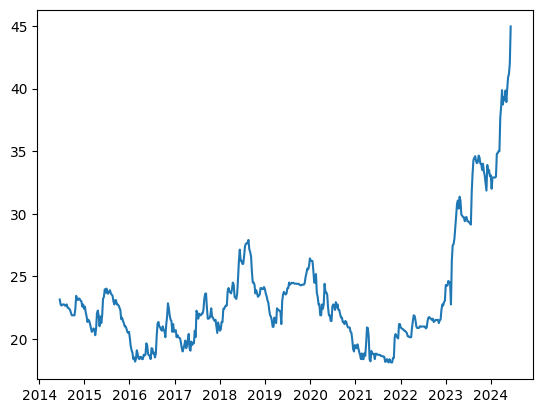

In [151]:
plt.plot(df.index, df['closingPrice'])